In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BULDING DATASET

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def combined_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    accelerator.print(current_train_size, checkpoints[-1] - target_samples)
    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get KMeans samples
        kmeans_indices = get_kmeans_samples(model, dataloader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")
        
        # Get Monte Carlo samples
        mc_indices = get_monte_carlo_samples(model, dataloader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(kmeans_indices).union(set(mc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_kmeans_samples(model, dataloader, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    
    # Cluster the data based on its embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        
        if cluster_indices.size == 0:
            # Skip clusters with no members
            continue
        
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
        
        # Determine the local threshold (90th percentile of distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        
        # Get indices of points with distances greater than or equal to threshold
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)
    
    # Randomly shuffle and select required number of samples
    collected_indices = np.array(list(collected_indices))
    
    # Return only the requested number of samples
    return collected_indices[:n_samples]

def get_monte_carlo_samples(model, dataloader, device, n_samples):
    model.train()

    confidences = []
    # Calculate uncertainties
    for data in dataloader:
        batch_probs = []
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)

        for _ in range(3):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = 'hsd-mc-kmeans'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.8269, F1 Micro: 0.2966, F1 Macro: 0.0666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4175, Accuracy: 0.8496, F1 Micro: 0.3363, F1 Macro: 0.1027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4037, Accuracy: 0.8525, F1 Micro: 0.4449, F1 Macro: 0.1501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3654, Accuracy: 0.8778, F1 Micro: 0.5782, F1 Macro: 0.2654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3353, Accuracy: 0.8846, F1 Micro: 0.5924, F1 Macro: 0.2966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2927, Accuracy: 0.8898, F1 Micro: 0.6519, F1 Macro: 0.3686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.255, Accuracy: 0.8912, F1 Micro: 0.664, F1 Macro: 0.431
Epoch 8/10, Train Loss: 0.2373, Accuracy: 0.8946, F1 Micro: 0.6626, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2062, Accuracy: 0.8957, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5067, Accuracy: 0.8396, F1 Micro: 0.2854, F1 Macro: 0.0817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4084, Accuracy: 0.8533, F1 Micro: 0.4027, F1 Macro: 0.1182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3729, Accuracy: 0.879, F1 Micro: 0.5525, F1 Macro: 0.253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.327, Accuracy: 0.8885, F1 Micro: 0.6206, F1 Macro: 0.3177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2885, Accuracy: 0.8932, F1 Micro: 0.6753, F1 Macro: 0.4145
Epoch 6/10, Train Loss: 0.2463, Accuracy: 0.8974, F1 Micro: 0.6706, F1 Macro: 0.4047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2164, Accuracy: 0.9027, F1 Micro: 0.7009, F1 Macro: 0.4934
Epoch 8/10, Train Loss: 0.1899, Accuracy: 0.9026, F1 Micro: 0.6936, F1 Macro: 0.4983
Epoch 9/10, Train Loss: 0.1683, Accuracy: 0.9039, F1 Micro: 0.6802, F1 Macro: 0.5088
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8354, F1 Micro: 0.1168, F1 Macro: 0.0411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3979, Accuracy: 0.87, F1 Micro: 0.5157, F1 Macro: 0.2178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3424, Accuracy: 0.8894, F1 Micro: 0.6527, F1 Macro: 0.3433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3037, Accuracy: 0.8995, F1 Micro: 0.6747, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2517, Accuracy: 0.9039, F1 Micro: 0.6871, F1 Macro: 0.4703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2191, Accuracy: 0.9067, F1 Micro: 0.7009, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1868, Accuracy: 0.9083, F1 Micro: 0.7222, F1 Macro: 0.5384
Epoch 8/10, Train Loss: 0.1562, Accuracy: 0.9092, F1 Micro: 0.717, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1318, Accuracy: 0.9068, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4695, Accuracy: 0.8488, F1 Micro: 0.3528, F1 Macro: 0.1041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3873, Accuracy: 0.8806, F1 Micro: 0.5841, F1 Macro: 0.2734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3323, Accuracy: 0.8938, F1 Micro: 0.6658, F1 Macro: 0.3671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2808, Accuracy: 0.9048, F1 Micro: 0.6934, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.238, Accuracy: 0.9066, F1 Micro: 0.7258, F1 Macro: 0.5385
Epoch 6/10, Train Loss: 0.2049, Accuracy: 0.9106, F1 Micro: 0.7258, F1 Macro: 0.526
Epoch 7/10, Train Loss: 0.1773, Accuracy: 0.9133, F1 Micro: 0.7251, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1497, Accuracy: 0.9101, F1 Micro: 0.729, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1271, Accuracy: 0.9142, F1 Micro: 0.7309, F1 Macro: 0.5772
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4624, Accuracy: 0.8499, F1 Micro: 0.4076, F1 Macro: 0.1164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3721, Accuracy: 0.8828, F1 Micro: 0.6125, F1 Macro: 0.2893
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.31, Accuracy: 0.8972, F1 Micro: 0.6643, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.259, Accuracy: 0.9059, F1 Micro: 0.7094, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2292, Accuracy: 0.9102, F1 Micro: 0.717, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1962, Accuracy: 0.9131, F1 Micro: 0.7386, F1 Macro: 0.5577
Epoch 7/10, Train Loss: 0.162, Accuracy: 0.9152, F1 Micro: 0.7317, F1 Macro: 0.5758
Epoch 8/10, Train Loss: 0.1335, Accuracy: 0.914, F1 Micro: 0.7271, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1216, Accuracy: 0.9126, F1 Micro: 0.7528, F1 Macro: 0.6066
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4534, Accuracy: 0.8566, F1 Micro: 0.3932, F1 Macro: 0.1233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3626, Accuracy: 0.8892, F1 Micro: 0.6322, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.8992, F1 Micro: 0.7078, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2557, Accuracy: 0.9094, F1 Micro: 0.7242, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2156, Accuracy: 0.9135, F1 Micro: 0.7328, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1834, Accuracy: 0.913, F1 Micro: 0.7405, F1 Macro: 0.5663
Epoch 7/10, Train Loss: 0.1508, Accuracy: 0.9171, F1 Micro: 0.7395, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1277, Accuracy: 0.9204, F1 Micro: 0.758, F1 Macro: 0.6427
Epoch 9/10, Train Loss: 0.1118, Accuracy: 0.9181, F1 Micro: 0.7546, F1 Macro: 0.6356
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4516, Accuracy: 0.8601, F1 Micro: 0.4491, F1 Macro: 0.1654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3502, Accuracy: 0.8918, F1 Micro: 0.6573, F1 Macro: 0.3786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2924, Accuracy: 0.9007, F1 Micro: 0.7156, F1 Macro: 0.501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2513, Accuracy: 0.9111, F1 Micro: 0.7177, F1 Macro: 0.5363
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.214, Accuracy: 0.9167, F1 Micro: 0.744, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1799, Accuracy: 0.9151, F1 Micro: 0.7501, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9121, F1 Micro: 0.7506, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1288, Accuracy: 0.9162, F1 Micro: 0.7586, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8626, F1 Micro: 0.4654, F1 Macro: 0.1617
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3369, Accuracy: 0.8953, F1 Micro: 0.6631, F1 Macro: 0.3958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2837, Accuracy: 0.9067, F1 Micro: 0.7234, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2405, Accuracy: 0.9144, F1 Micro: 0.742, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2036, Accuracy: 0.9148, F1 Micro: 0.743, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1684, Accuracy: 0.9195, F1 Micro: 0.7601, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1408, Accuracy: 0.921, F1 Micro: 0.7656, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.9191, F1 Micro: 0.7622, F1 Macro: 0.624
Epoch 9/10, Train Loss: 0.1039, Accuracy: 0.9167, F1 Micro: 0.7638, F1 Macro: 0.6633
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4452, Accuracy: 0.8648, F1 Micro: 0.4413, F1 Macro: 0.1587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3368, Accuracy: 0.8963, F1 Micro: 0.6816, F1 Macro: 0.432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.9061, F1 Micro: 0.7289, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.234, Accuracy: 0.9133, F1 Micro: 0.7297, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2046, Accuracy: 0.9169, F1 Micro: 0.7553, F1 Macro: 0.6169
Epoch 6/10, Train Loss: 0.1693, Accuracy: 0.9182, F1 Micro: 0.7491, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.144, Accuracy: 0.9216, F1 Micro: 0.7629, F1 Macro: 0.642
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.915, F1 Micro: 0.7616, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1035, Accuracy: 0.9195, F1 Micro: 0.7655, F1 Macro: 0.6678
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4367, Accuracy: 0.8721, F1 Micro: 0.5206, F1 Macro: 0.2242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3257, Accuracy: 0.8986, F1 Micro: 0.6848, F1 Macro: 0.4232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2706, Accuracy: 0.909, F1 Micro: 0.724, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2243, Accuracy: 0.9151, F1 Micro: 0.7405, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9197, F1 Micro: 0.7501, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.9202, F1 Micro: 0.7544, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9219, F1 Micro: 0.7632, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.92, F1 Micro: 0.7666, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4358, Accuracy: 0.8782, F1 Micro: 0.5744, F1 Macro: 0.2607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3186, Accuracy: 0.9019, F1 Micro: 0.6967, F1 Macro: 0.4676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.9096, F1 Micro: 0.7101, F1 Macro: 0.5452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.9158, F1 Micro: 0.7362, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1856, Accuracy: 0.9175, F1 Micro: 0.7538, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1556, Accuracy: 0.9193, F1 Micro: 0.7599, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.132, Accuracy: 0.9217, F1 Micro: 0.7726, F1 Macro: 0.6643
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9203, F1 Micro: 0.7661, F1 Macro: 0.67
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.9194, F1 Micro: 0.7652, F1 Macro: 0.6747
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8797, F1 Micro: 0.5909, F1 Macro: 0.2759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3164, Accuracy: 0.9019, F1 Micro: 0.6937, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2578, Accuracy: 0.9122, F1 Micro: 0.7304, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.917, F1 Micro: 0.7402, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9192, F1 Micro: 0.7627, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9186, F1 Micro: 0.7653, F1 Macro: 0.6368
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.92, F1 Micro: 0.7652, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9231, F1 Micro: 0.7659, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9214, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.8807, F1 Micro: 0.5893, F1 Macro: 0.2853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.9018, F1 Micro: 0.7074, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2522, Accuracy: 0.9123, F1 Micro: 0.7293, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2157, Accuracy: 0.9147, F1 Micro: 0.7503, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1839, Accuracy: 0.9139, F1 Micro: 0.7592, F1 Macro: 0.6439
Epoch 6/10, Train Loss: 0.1508, Accuracy: 0.9216, F1 Micro: 0.7547, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9201, F1 Micro: 0.7664, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9235, F1 Micro: 0.769, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9199, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.424, Accuracy: 0.8795, F1 Micro: 0.5538, F1 Macro: 0.2678
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.301, Accuracy: 0.9036, F1 Micro: 0.6919, F1 Macro: 0.4637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2503, Accuracy: 0.9116, F1 Micro: 0.7356, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9182, F1 Micro: 0.7365, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9211, F1 Micro: 0.7654, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9216, F1 Micro: 0.765, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1263, Accuracy: 0.9195, F1 Micro: 0.7728, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.9226, F1 Micro: 0.7742, F1 Macro: 0.6839
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9229, F1 Micro: 0.7736, F1 Macro: 0.6793
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4182, Accuracy: 0.8826, F1 Micro: 0.5843, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2978, Accuracy: 0.9054, F1 Micro: 0.7035, F1 Macro: 0.5076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2462, Accuracy: 0.9153, F1 Micro: 0.7343, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2054, Accuracy: 0.9172, F1 Micro: 0.7588, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9198, F1 Micro: 0.77, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9237, F1 Micro: 0.7737, F1 Macro: 0.6633
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9235, F1 Micro: 0.7717, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9225, F1 Micro: 0.7765, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0914, Accuracy: 0.9253, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4183, Accuracy: 0.8843, F1 Micro: 0.6014, F1 Macro: 0.2986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.9049, F1 Micro: 0.7034, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2412, Accuracy: 0.9137, F1 Micro: 0.7414, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9209, F1 Micro: 0.7555, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9195, F1 Micro: 0.7687, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9236, F1 Micro: 0.7717, F1 Macro: 0.6571
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9217, F1 Micro: 0.7706, F1 Macro: 0.67
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9206, F1 Micro: 0.7682, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9225, F1 Micro: 0.7783, F1 Macro: 0.6864
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8836, F1 Micro: 0.5931, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2927, Accuracy: 0.905, F1 Micro: 0.6886, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.916, F1 Micro: 0.7448, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9213, F1 Micro: 0.7599, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1687, Accuracy: 0.9223, F1 Micro: 0.7643, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9236, F1 Micro: 0.7742, F1 Macro: 0.6664
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9231, F1 Micro: 0.7714, F1 Macro: 0.685
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9182, F1 Micro: 0.7709, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9223, F1 Micro: 0.7613, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8859, F1 Micro: 0.6163, F1 Macro: 0.3006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.9071, F1 Micro: 0.7074, F1 Macro: 0.5108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.9168, F1 Micro: 0.7389, F1 Macro: 0.5682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9176, F1 Micro: 0.7588, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9191, F1 Micro: 0.7689, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9238, F1 Micro: 0.7697, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9197, F1 Micro: 0.7744, F1 Macro: 0.6911
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9224, F1 Micro: 0.7732, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9255, F1 Micro: 0.7723, F1 Macro: 0.6842
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4054, Accuracy: 0.8844, F1 Micro: 0.5834, F1 Macro: 0.2892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2805, Accuracy: 0.9041, F1 Micro: 0.6781, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9138, F1 Micro: 0.7495, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9206, F1 Micro: 0.76, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9216, F1 Micro: 0.7647, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9197, F1 Micro: 0.7659, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9214, F1 Micro: 0.7727, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9273, F1 Micro: 0.778, F1 Macro: 0.6819
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9229, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.8872, F1 Micro: 0.6252, F1 Macro: 0.3256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.906, F1 Micro: 0.6972, F1 Macro: 0.5071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9166, F1 Micro: 0.7428, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9212, F1 Micro: 0.7715, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9229, F1 Micro: 0.7734, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9239, F1 Micro: 0.7783, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9223, F1 Micro: 0.7789, F1 Macro: 0.689
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9246, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8862, F1 Micro: 0.6346, F1 Macro: 0.327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9065, F1 Micro: 0.7237, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.9163, F1 Micro: 0.7505, F1 Macro: 0.5643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.92, F1 Micro: 0.7686, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9227, F1 Micro: 0.7718, F1 Macro: 0.6546
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9232, F1 Micro: 0.7611, F1 Macro: 0.6631
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.924, F1 Micro: 0.758, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9242, F1 Micro: 0.7797, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9242, F1 Micro: 0.7754, F1 Macro: 0.6912
Epoch 10/10, Train Loss: 0.0691, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8872, F1 Micro: 0.616, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.9063, F1 Micro: 0.7109, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9149, F1 Micro: 0.7531, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9212, F1 Micro: 0.7648, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9238, F1 Micro: 0.7715, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9209, F1 Micro: 0.7747, F1 Macro: 0.6699
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9205, F1 Micro: 0.7709, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9257, F1 Micro: 0.7767, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9258, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.888, F1 Micro: 0.6375, F1 Macro: 0.3229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.9077, F1 Micro: 0.7195, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9159, F1 Micro: 0.7358, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9207, F1 Micro: 0.7668, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9224, F1 Micro: 0.7696, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9224, F1 Micro: 0.7689, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9257, F1 Micro: 0.7778, F1 Macro: 0.6848
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9215, F1 Micro: 0.7778, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9219, F1 Micro: 0.7759, F1 Macro: 0.7046
Epoch 10/10, Train Loss: 0.0678, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.8882, F1 Micro: 0.6202, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9076, F1 Micro: 0.6914, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9132, F1 Micro: 0.7494, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9159, F1 Micro: 0.7623, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9209, F1 Micro: 0.7706, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9229, F1 Micro: 0.7749, F1 Macro: 0.6699
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9167, F1 Micro: 0.7676, F1 Macro: 0.6635
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9226, F1 Micro: 0.7712, F1 Macro: 0.6746
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.923, F1 Micro: 0.7696, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8779, F1 Micro: 0.5186, F1 Macro: 0.2454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9078, F1 Micro: 0.7003, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9169, F1 Micro: 0.7427, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9187, F1 Micro: 0.7567, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9195, F1 Micro: 0.7682, F1 Macro: 0.6298
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9222, F1 Micro: 0.7638, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9214, F1 Micro: 0.7727, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9218, F1 Micro: 0.7693, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9265, F1 Micro: 0.7799, F1 Macro: 0.7003
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8868, F1 Micro: 0.5962, F1 Macro: 0.2995
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9061, F1 Micro: 0.6972, F1 Macro: 0.4595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9156, F1 Micro: 0.75, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9202, F1 Micro: 0.7561, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9182, F1 Micro: 0.7609, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9242, F1 Micro: 0.7772, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9236, F1 Micro: 0.7787, F1 Macro: 0.6924
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9214, F1 Micro: 0.7757, F1 Macro: 0.6884
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9239, F1 Micro: 0.7721, F1 Macro: 0.681
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8889, F1 Micro: 0.628, F1 Macro: 0.3302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9053, F1 Micro: 0.6797, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9144, F1 Micro: 0.7348, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9199, F1 Micro: 0.7401, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9225, F1 Micro: 0.7573, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9241, F1 Micro: 0.7781, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9244, F1 Micro: 0.7766, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9242, F1 Micro: 0.7753, F1 Macro: 0.6872
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9211, F1 Micro: 0.7715, F1 Macro: 0.697
Epoch 10/10, Train Loss: 0.0612, Accurac

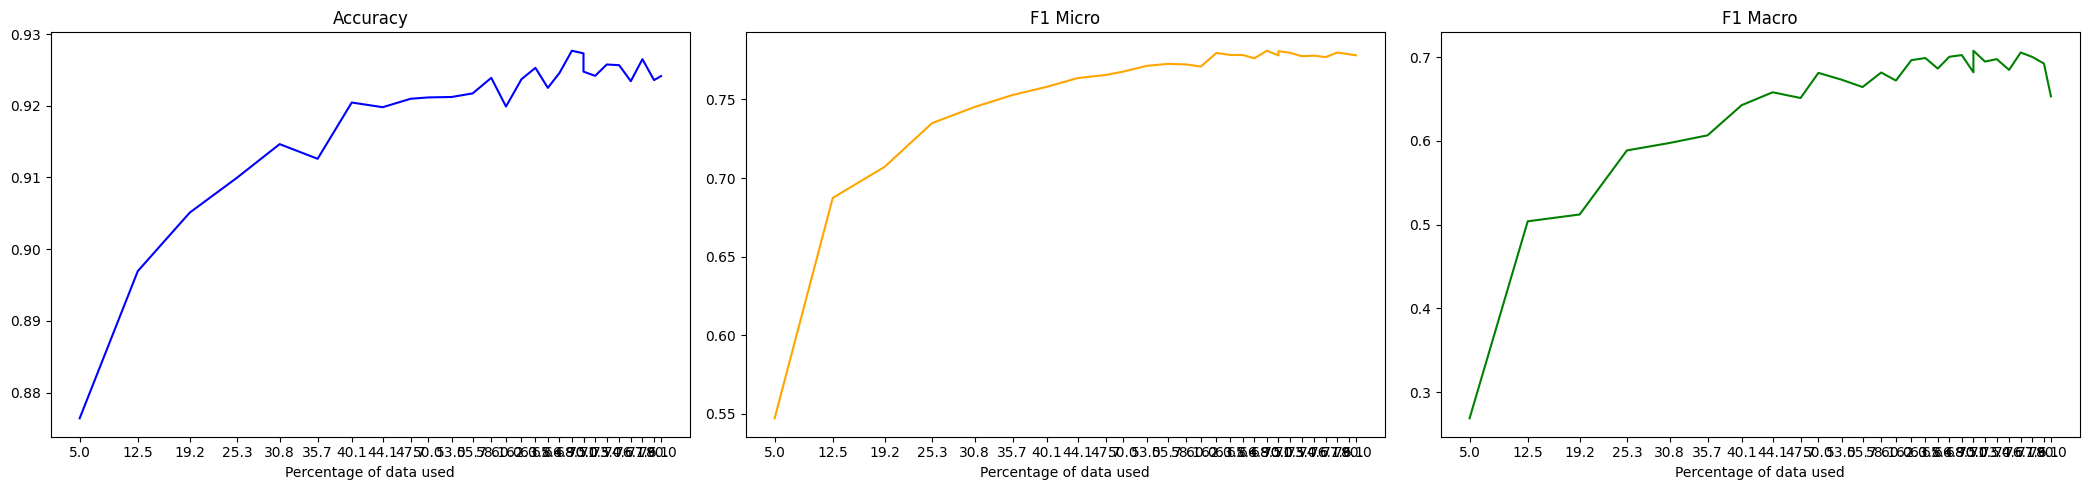

In [19]:
active_learning(seeds[0], 0)